In [ ]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
print(train_data.shape)
print(test_data.shape)

(191, 13)
(48, 13)


# Preprocessing

## Drop delle colonne ritenute superflue, separazione train/test in X, y

Vedere la fine del notebook di preparazione per le motivazioni del drop di time

In [5]:
X_train = train_data.drop(columns=['DEATH_EVENT', 'time'])
y_train = train_data['DEATH_EVENT']

X_test = test_data.drop(columns=['DEATH_EVENT', 'time'])
y_test = test_data['DEATH_EVENT']

Il dataset ha solo colonne int64 o float64, qualsiasi valore sporco viene convertito in NaN e poi dato in pasto al SimpleImputer nella Pipeline per sostituirlo con un valore numerico.

In [6]:
X_train = X_train.apply(pd.to_numeric, errors = 'coerce')
X_test = X_test.apply(pd.to_numeric, errors = 'coerce')

In [7]:
X_train.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
dtype: int64

### Pulizia di tutti i valori np.NaN

In [8]:
X_train = X_train.fillna(X_train.mean().round())
X_test = X_test.fillna(X_test.mean().round())

In [9]:
X_train.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
dtype: int64

### Conversione in colonne intere e scaling di alcune feature

platelets e serum_creatinine hanno valori min/max in range grandi o piccoli, li normalizziamo

In [10]:
X_train.platelets.describe()

count       191.000000
mean     266520.264136
std       91414.440907
min       47000.000000
25%      217500.000000
50%      263358.030000
75%      303500.000000
max      742000.000000
Name: platelets, dtype: float64

In [11]:
X_train.serum_creatinine.describe()

count    191.000000
mean       1.297853
std        0.649890
min        0.600000
25%        0.900000
50%        1.100000
75%        1.400000
max        5.000000
Name: serum_creatinine, dtype: float64

In [12]:
X_train.platelets = X_train.platelets / 10**3
X_train.serum_creatinine = X_train.serum_creatinine * 10**2

X_test.platelets = X_test.platelets / 10**3
X_test.serum_creatinine = X_test.serum_creatinine * 10**2

In [13]:
X_train = X_train.round().astype(np.int64)
X_test = X_test.round().astype(np.int64)

In [14]:
X_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,55,0,1820,0,38,0,270,120,139,0,0
1,68,1,220,0,35,1,289,90,140,1,1
2,42,0,5209,0,30,0,226,100,140,1,1
3,50,1,121,1,40,0,260,70,130,1,0
4,50,1,168,0,38,1,276,110,137,1,0


### Feature che considera tutti i fattori di rischio (booleani) insieme (risk_factor)

In [15]:
boolean_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'smoking']

In [16]:
X_train[boolean_features].sum(axis=1)
X_train['risk_factor'] = X_train[boolean_features].sum(axis=1)
X_train = X_train.drop(columns=boolean_features)

X_test[boolean_features].sum(axis=1)
X_test['risk_factor'] = X_test[boolean_features].sum(axis=1)
X_test = X_test.drop(columns=boolean_features)

In [17]:
X_train.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,sex,risk_factor
0,55,1820,38,270,120,139,0,0
1,68,220,35,289,90,140,1,3
2,42,5209,30,226,100,140,1,1
3,50,121,40,260,70,130,1,2
4,50,168,38,276,110,137,1,2


In [18]:
X_train.dtypes

age                         int64
creatinine_phosphokinase    int64
ejection_fraction           int64
platelets                   int64
serum_creatinine            int64
serum_sodium                int64
sex                         int64
risk_factor                 int64
dtype: object

# Scelta dei modelli, training e fit

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

### Pipeline

La Pipeline è utile per concatenare diverse operazioni di trasformazione (tra cui imputation, scaling e altro) facendo fit_transform su training set e transform su test set. Per ultimo l'utilizzo di un modello per fare il fit sui dati di training e il predict sui dati di test.

GridSearchCV prenderà come parametri la Pipeline (su cui fare fit_transform/transform a seconda dei dati di train/test) e il numero di k-fold da effettuare nella Cross Validation.

In [20]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', DecisionTreeClassifier())
        ])

Il tuning dei parametri risulta fondamentale per evitare overfitting, in particolare per il DecisionTreeClassifier che con depth > 7 presenta questo problema in modo significativo (anche per depth = 1 c'erano problemi per la selezione di una sola feature nel decision stump). 

Valori di profondità alti per un DecisionTree corrispondono ad un'alta complessità del modello, che è da evitare. Così come i pesi nella LogisticRegression vengono limitati dalla penalty L1 o L2. 

Il dataset ha pochi elementi, si deve evitare under/overfitting mantenendo la complessità del modello ad un livello intermedio.

In [21]:
params = [
            {'model': [DecisionTreeClassifier()],
            #'model__criterion': ['gini', 'entropy'],
            #'model__splitter': ['best', 'random'],
            #'model__min_samples_split': [1, 2, 3],
            #'model__min_samples_leaf': [1, 2, 3],
            'model__max_features': ['auto', 'sqrt'],
            'model__max_depth': np.arange(2,7)},
            {'model': [LogisticRegression()],
            'model__max_iter': [1000],
            'model__penalty': ['l2', 'l1'],
            'model__C': np.logspace(0, 3, 20)},
            #{'model': [RandomForestClassifier()],
            #'model__n_estimators': [10, 100],
            #'model__max_features': ['auto', 'sqrt'],
            #'model__min_samples_leaf': [1, 4],
            #'model__min_samples_split': [2, 10],
            #'model__max_depth': np.arange(1,8)},
            #{'model': [KNeighborsClassifier()],
            #'model__n_neighbors': np.arange(2,8),
            #'model__leaf_size': list(range(10,30)),
            #'model__p': [1, 2]}
            ]

### GridSearchCV

La GridSearchCV è utile per stimare il modello coi migliori parametri, per ogni combinazione dei modelli e parametri forniti. Viene anche effettuata la Cross Validation (CV) per rendere più affidabile lo score calcolato (valori di k-fold ottimali sono k=5 e k=10, ed anche k=20 è stato testato con ottimi risultati). 

La Leave-One-Out con k=n_osservazioni non viene consigliata nella pratica, e non è neanche possibile utilizzarla nella GridSearchCV poiché essa usa una StratifiedKFold, che mantiene le proporzioni delle classi di target nel validation set, necessitando che ci sia almeno un rappresentante per ogni valore possibile.

Si effettua quindi una ricerca nello spazio dei parametri dei classificatori indicati, facendo fit su tutte le possibili combinazioni specificate tramite la lista dizionari params. Infine sceglie il miglior modello e suoi migliori parametri da una tabella che calcola man mano (gridsearch.cv_results_) dove ci sono i ranking di tutte le possibili scelte effettuate.

NOTA: Se il GridSearch con n_jobs=4 provoca problemi (freeze/computazione che non termina/altro) potrebbe dipendere dall'OS utilizzato. Per un funzionamento stabile usare n_jobs=1

In [22]:
from sklearn.model_selection import GridSearchCV
gridsearch = GridSearchCV(pipe, params, cv=20, verbose=1, n_jobs=4).fit(X_train, y_train) #cv=5 o 10
#print('Score migliore di test accuracy: ', gridsearch.score(X_test, y_test))

Fitting 20 folds for each of 50 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   16.8s finished


Di seguito la classifica dei migliori modelli valutati dalla GridSearch, ordinati per media degli score calcolati durante la CV

In [23]:
gs = pd.DataFrame(gridsearch.cv_results_)
ranking = gs[['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score', ascending=True).head(10)
ranking

,params,mean_test_score,rank_test_score
28,{'model': LogisticRegression(C=26.366508987303...,0.758333,1
30,{'model': LogisticRegression(C=26.366508987303...,0.758333,1
46,{'model': LogisticRegression(C=26.366508987303...,0.758333,1
44,{'model': LogisticRegression(C=26.366508987303...,0.758333,1
42,{'model': LogisticRegression(C=26.366508987303...,0.758333,1
32,{'model': LogisticRegression(C=26.366508987303...,0.758333,1
40,{'model': LogisticRegression(C=26.366508987303...,0.758333,1
48,{'model': LogisticRegression(C=26.366508987303...,0.758333,1
38,{'model': LogisticRegression(C=26.366508987303...,0.758333,1
34,{'model': LogisticRegression(C=26.366508987303...,0.758333,1


In [24]:
for rank in ranking['params']:
    print(rank)

{'model': LogisticRegression(C=26.366508987303583, max_iter=1000), 'model__C': 26.366508987303583, 'model__max_iter': 1000, 'model__penalty': 'l2'}
{'model': LogisticRegression(C=26.366508987303583, max_iter=1000), 'model__C': 37.926901907322495, 'model__max_iter': 1000, 'model__penalty': 'l2'}
{'model': LogisticRegression(C=26.366508987303583, max_iter=1000), 'model__C': 695.1927961775606, 'model__max_iter': 1000, 'model__penalty': 'l2'}
{'model': LogisticRegression(C=26.366508987303583, max_iter=1000), 'model__C': 483.2930238571752, 'model__max_iter': 1000, 'model__penalty': 'l2'}
{'model': LogisticRegression(C=26.366508987303583, max_iter=1000), 'model__C': 335.9818286283781, 'model__max_iter': 1000, 'model__penalty': 'l2'}
{'model': LogisticRegression(C=26.366508987303583, max_iter=1000), 'model__C': 54.55594781168517, 'model__max_iter': 1000, 'model__penalty': 'l2'}
{'model': LogisticRegression(C=26.366508987303583, max_iter=1000), 'model__C': 233.57214690901213, 'model__max_iter'

Informazioni sui parametri del miglior modello trovato, e sull'importanza delle feature per la classificazione

In [25]:
best_grid_model = gridsearch.best_estimator_['model']

print(best_grid_model)
best_grid_model.get_params()

LogisticRegression(C=26.366508987303583, max_iter=1000)


{'C': 26.366508987303583,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Se il modello scelto è un DecisionTree vengono visualizzate le feature da esso utilizzato. In alcuni casi anche la nuova feature 'risk_factor' è stata usata

In [26]:
if(type(best_grid_model).__name__ in ('DecisionTreeClassifier', 'RandomForestClassifier')):
    sns.set_style("whitegrid")

    fig, axes = plt.subplots(nrows = 1, ncols = 1, sharex="all", figsize=(8,6))

    indices = np.argsort(best_grid_model.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40],x = best_grid_model.feature_importances_[indices][:40] , orient='h')
    g.set_xlabel("Relative importance",fontsize=12)
    g.set_ylabel("Features",fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(type(best_grid_model).__name__ + " feature importance")

In [27]:
if(type(best_grid_model).__name__ == 'DecisionTreeClassifier' ):
    fig = plt.figure(figsize=(15,10))
    _ = tree.plot_tree(best_grid_model, 
                   feature_names=X_train.columns,  
                   class_names=y_train.name,
                   filled=True)

## Confusion Matrix

I valori sulle righe sono i true value, le colonne della matrice quelli predetti. Non ci sono situazioni in cui il classificatore risponde in modo anomalo (ad esempio sempre nello stesso modo).

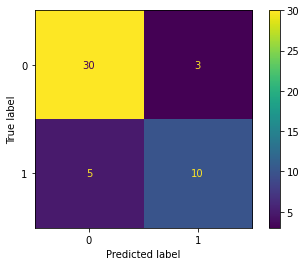

In [28]:
plot_confusion_matrix(gridsearch.best_estimator_[1], X_test, y_test) #normalize='true'
plt.grid(False)
plt.show()

## Risultato di Accuracy del miglior modello scelto

Il valore di Test Accuracy qui mostrato è relativo a un solo predict del modello scelto come migliore tra tutti. La accuracy è molto sensibile dato che ci sono poche osservazioni nel dataset, e i suoi valori più realistici sono nella tabella della GridSearchCV mostrati precedentemente in "mean_test_score".

In alcune istanze di esecuzione la accuracy di testing supera quella di training (cosa solitamente rara), per via dei pochi dati di training che non rendono affidabile la singola percentuale di un predict.

A seconda dell'istanza di esecuzione e dello split train/test a monte potrebbe essere scelto un DecisionTreeClassifier o un modello LogisticRegression (entrambi con alcuni parametri ottimizzati dalla GridSearchCV).

In [29]:
best_grid_model = gridsearch.best_estimator_['model']
print(best_grid_model)
print('Training Accuracy: ', best_grid_model.score(X_train, y_train) * 100, '%')
print('Testing Accuracy: ', best_grid_model.score(X_test, y_test) * 100, '%')

LogisticRegression(C=26.366508987303583, max_iter=1000)
Training Accuracy:  76.96335078534031 %
Testing Accuracy:  83.33333333333334 %
